In [1]:
import os
import polars as pl
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as MAE

### Importing data

In [2]:
path = "/Users/afnan/Desktop/python/Data_science_Notes/Uber_data/4_ETA/preprocessed"

In [3]:
all_files = os.listdir("preprocessed/")
parquet_files = [file for file in all_files if file.endswith(".parquet")]

In [4]:
feature_cols = ['taxi_company', 'trip_miles',  'wav_request_flag', 'wav_match_flag', 'dispatching_base_num', 
                'PULocationID', 'PUBorough', 'PUservice_zone', 'DOLocationID', 'DOBorough', 'DOservice_zone', 
                'any_tolls', 'hour_of_day', 'day_of_week', 'month', 'traffic',
                'feel', 'humidity', 'BR', 'CLR', 'SN', 'wind_speed', 'wind_direction',
                'trip_time', 'minutes_per_mile']

In [5]:
len(feature_cols)

25

In [6]:
df1 = pl.read_parquet(f"{path}/{parquet_files[0]}", columns=feature_cols)
df2 = pl.read_parquet(f"{path}/{parquet_files[1]}", columns=feature_cols)
df3 = pl.read_parquet(f"{path}/{parquet_files[2]}", columns=feature_cols)
df4 = pl.read_parquet(f"{path}/{parquet_files[3]}", columns=feature_cols)
df5 = pl.read_parquet(f"{path}/{parquet_files[4]}", columns=feature_cols)
df6 = pl.read_parquet(f"{path}/{parquet_files[5]}", columns=feature_cols)
df7 = pl.read_parquet(f"{path}/{parquet_files[6]}", columns=feature_cols)
df8 = pl.read_parquet(f"{path}/{parquet_files[7]}", columns=feature_cols)

In [7]:
dfs = [df1, df2, df3, df4, df5, df6, df7, df8]

In [8]:
combined_df = pl.concat(dfs)

In [9]:
combined_df.head()

taxi_company,trip_miles,wav_request_flag,wav_match_flag,dispatching_base_num,PULocationID,PUBorough,PUservice_zone,DOLocationID,DOBorough,DOservice_zone,any_tolls,hour_of_day,day_of_week,month,traffic,feel,humidity,BR,CLR,SN,wind_speed,wind_direction,trip_time,minutes_per_mile
str,f64,i32,i32,str,i64,str,str,i64,str,str,i32,i32,str,str,i32,f64,f64,i64,i64,i64,f64,str,f64,f64
"""Lyft""",2.1,0,0,"""B02510""",39,"""Brooklyn""","""Boro Zone""",72,"""Brooklyn""","""Boro Zone""",0,14,"""Sunday""","""July""",24000,73.9,81.82,0,1,0,9.0,"""SE""",11.55,5.5
"""Uber""",1.99,0,0,"""B02866""",141,"""Manhattan""","""Yellow Zone""",164,"""Manhattan""","""Yellow Zone""",0,14,"""Sunday""","""July""",24000,73.9,81.82,0,1,0,9.0,"""SE""",11.366667,5.711893
"""Uber""",1.1,0,0,"""B02764""",222,"""Brooklyn""","""Boro Zone""",76,"""Brooklyn""","""Boro Zone""",0,14,"""Sunday""","""July""",24000,73.9,81.82,0,1,0,9.0,"""SE""",6.916667,6.287879
"""Uber""",1.7,0,0,"""B02836""",250,"""Bronx""","""Boro Zone""",242,"""Bronx""","""Boro Zone""",0,14,"""Sunday""","""July""",24000,73.9,81.82,0,1,0,9.0,"""SE""",10.25,6.029412
"""Uber""",3.73,0,0,"""B02872""",256,"""Brooklyn""","""Boro Zone""",148,"""Manhattan""","""Yellow Zone""",0,14,"""Sunday""","""July""",24000,73.9,81.82,0,1,0,9.0,"""SE""",18.966667,5.084897


##### Label encoding

In [10]:
month_mapping = { "January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6, "July": 7,
                  "August": 8, "September": 9, "October": 10, "November": 11, "December": 12
                }

day_of_week_mapping = {
    "Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7
}

borough_mapping = { "Queens": 1, "Manhattan": 2, "Bronx": 3, "Staten Island": 4, "Brooklyn": 5, "EWR": 6 }
zone_mapping = {"Yellow Zone":1, "Boro Zone":2, "Airports":3}

In [11]:
combined_df = combined_df.with_columns(pl.col("month").replace(month_mapping).cast(pl.Int64, strict=False))

combined_df = combined_df.with_columns(pl.col("day_of_week").replace(day_of_week_mapping).cast(pl.Int64, strict=False))

combined_df = combined_df.with_columns(pl.col("PUBorough").replace(borough_mapping).cast(pl.Int64, strict=False))
combined_df = combined_df.with_columns(pl.col("DOBorough").replace(borough_mapping).cast(pl.Int64, strict=False))

combined_df = combined_df.with_columns(pl.col("PUservice_zone").replace(zone_mapping).cast(pl.Int64, strict=False))
combined_df = combined_df.with_columns(pl.col("DOservice_zone").replace(zone_mapping).cast(pl.Int64, strict=False))

In [12]:
string_columns = combined_df.select([pl.col(pl.String)]).columns

In [13]:
for column in string_columns:
    le = LabelEncoder()
    encoded_values = le.fit(combined_df[column])
    column_map = dict(zip(combined_df[column], le.transform(combined_df[column])))
    print(column_map)
    combined_df = combined_df.with_columns(pl.col(column).replace(column_map).cast(pl.Int64, strict=False))

{'Lyft': 0, 'Uber': 1, 'Via': 2}
{'B02510': 1, 'B02866': 13, 'B02764': 5, 'B02836': 9, 'B02872': 18, 'B02887': 28, 'B02765': 6, 'B02867': 14, 'B02877': 21, 'B02835': 8, 'B02883': 26, 'B02682': 4, 'B02876': 20, 'B02617': 3, 'B02882': 25, 'B02512': 2, 'B02869': 15, 'B02871': 17, 'B02878': 22, 'B02870': 16, 'B02864': 11, 'B02884': 27, 'B02395': 0, 'B02875': 19, 'B02865': 12, 'B02880': 24, 'B02889': 30, 'B02888': 29, 'B02879': 23, 'B02800': 7, 'B02844': 10, 'B03136': 31, 'B03406': 33, 'B03404': 32}
{'SE': 5, 'NW': 3, 'NE': 2, 'S': 4, 'N': 1, 'E': 0, 'SW': 6, 'W': 7}


##### Training columns

In [14]:
train_cols = [x for x in feature_cols if x not in ['trip_time', 'minutes_per_mile']]

### Hyperparameter tuning

In [15]:
# Dataset for hyperparameter tuning
tuning_df = combined_df[::20]

In [16]:
tuning_df.shape

(813858, 25)

In [17]:
train_X, X_test, train_y, y_test = train_test_split(tuning_df[train_cols], tuning_df[['minutes_per_mile', 'trip_time']], 
                                                    test_size=0.2, random_state=42)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, 
                                                    test_size=0.1, random_state=42)

In [19]:
# RandomizedSearchCV

In [20]:
param_grid = {"max_depth":    [10, 15, 20],
              "learning_rate": [0.1, 0.2, 0.3]} 

In [21]:
model = XGBRegressor(eval_metric='mae', early_stopping_rounds=10)

In [22]:
# grid = RandomizedSearchCV(model, param_grid).fit(X_train, y_train['minutes_per_mile'], 
#                          eval_set=[(X_val, y_val['minutes_per_mile'])])

In [23]:
# best parameter: max_depth = 10, learning_rate = 0.2

In [24]:
minute_model = XGBRegressor(eval_metric='mae', early_stopping_rounds=10,
                            n_estimators = 500, 
                            max_depth = 10,
                            learning_rate = 0.2)

In [25]:
eval_sets = [(X_train, y_train['minutes_per_mile']), (X_val, y_val['minutes_per_mile'])]

In [26]:
minute_model.fit(X_train, y_train['minutes_per_mile'], eval_set=eval_sets)

[0]	validation_0-mae:3.73614	validation_1-mae:3.73961
[1]	validation_0-mae:2.99008	validation_1-mae:2.99170
[2]	validation_0-mae:2.39802	validation_1-mae:2.39879
[3]	validation_0-mae:1.94202	validation_1-mae:1.94275
[4]	validation_0-mae:1.60680	validation_1-mae:1.60926
[5]	validation_0-mae:1.37271	validation_1-mae:1.37827
[6]	validation_0-mae:1.21546	validation_1-mae:1.22424
[7]	validation_0-mae:1.11227	validation_1-mae:1.12381
[8]	validation_0-mae:1.04640	validation_1-mae:1.06051
[9]	validation_0-mae:1.00392	validation_1-mae:1.02014
[10]	validation_0-mae:0.97739	validation_1-mae:0.99532
[11]	validation_0-mae:0.96085	validation_1-mae:0.98094
[12]	validation_0-mae:0.94993	validation_1-mae:0.97166
[13]	validation_0-mae:0.94248	validation_1-mae:0.96600
[14]	validation_0-mae:0.93731	validation_1-mae:0.96197
[15]	validation_0-mae:0.93087	validation_1-mae:0.95689
[16]	validation_0-mae:0.92735	validation_1-mae:0.95460
[17]	validation_0-mae:0.92416	validation_1-mae:0.95285
[18]	validation_0-ma

[149]	validation_0-mae:0.74430	validation_1-mae:0.88256
[150]	validation_0-mae:0.74355	validation_1-mae:0.88235
[151]	validation_0-mae:0.74305	validation_1-mae:0.88238
[152]	validation_0-mae:0.74196	validation_1-mae:0.88236
[153]	validation_0-mae:0.74141	validation_1-mae:0.88241
[154]	validation_0-mae:0.74082	validation_1-mae:0.88239
[155]	validation_0-mae:0.74034	validation_1-mae:0.88243
[156]	validation_0-mae:0.73961	validation_1-mae:0.88240
[157]	validation_0-mae:0.73888	validation_1-mae:0.88249
[158]	validation_0-mae:0.73784	validation_1-mae:0.88246
[159]	validation_0-mae:0.73698	validation_1-mae:0.88223
[160]	validation_0-mae:0.73658	validation_1-mae:0.88222
[161]	validation_0-mae:0.73573	validation_1-mae:0.88230
[162]	validation_0-mae:0.73547	validation_1-mae:0.88229
[163]	validation_0-mae:0.73446	validation_1-mae:0.88218
[164]	validation_0-mae:0.73352	validation_1-mae:0.88205
[165]	validation_0-mae:0.73252	validation_1-mae:0.88189
[166]	validation_0-mae:0.73159	validation_1-mae:

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [27]:
eval_results = minute_model.evals_result()

In [28]:
train_scores = eval_results['validation_0']['mae']
val_scores = eval_results['validation_1']['mae']
epochs = range(1, len(train_scores) + 1)

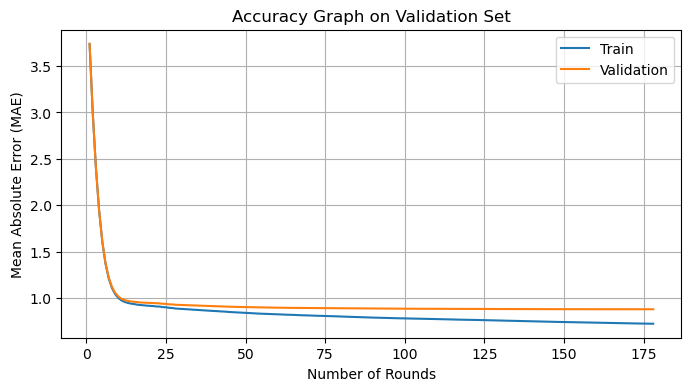

In [29]:
plt.figure(figsize=(8, 4))
plt.plot(epochs, train_scores, label='Train')
plt.plot(epochs, val_scores, label='Validation')
plt.xlabel('Number of Rounds')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Accuracy Graph on Validation Set')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Prediction on test data

In [31]:
minute_pred = minute_model.predict(X_test)

In [32]:
pred = minute_pred*X_test['trip_miles']

In [33]:
MAE(y_test['trip_time'], pred)

2.8864585377275978

### Model training on entire data

In [34]:
train_X, X_test, train_y, y_test = train_test_split(combined_df[train_cols], combined_df[['minutes_per_mile', 'trip_time']], 
                                                    test_size=0.01, random_state=42)

In [35]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y,
                                                    test_size=0.05, random_state=42)

##### Linear regression model

In [36]:
reg = LinearRegression().fit(train_X[['trip_miles']], train_y['trip_time'])

In [37]:
minute_reg_pred = reg.predict(X_test[['trip_miles']])

In [38]:
MAE(y_test['trip_time'], minute_reg_pred)

4.770922064831976

##### XGBRegressor

In [39]:
minute_model = XGBRegressor(eval_metric='mae', early_stopping_rounds=10,
                            n_estimators = 500, 
                            max_depth = 10,
                            learning_rate = 0.2)

In [40]:
eval_sets = [(X_train, y_train['minutes_per_mile']), (X_val, y_val['minutes_per_mile'])]

In [41]:
minute_model.fit(X_train, y_train['minutes_per_mile'], eval_set=eval_sets)

[0]	validation_0-mae:3.73442	validation_1-mae:3.73257
[1]	validation_0-mae:2.98794	validation_1-mae:2.98591
[2]	validation_0-mae:2.39606	validation_1-mae:2.39396
[3]	validation_0-mae:1.94063	validation_1-mae:1.93861
[4]	validation_0-mae:1.60735	validation_1-mae:1.60555
[5]	validation_0-mae:1.37450	validation_1-mae:1.37299
[6]	validation_0-mae:1.21959	validation_1-mae:1.21855
[7]	validation_0-mae:1.11860	validation_1-mae:1.11805
[8]	validation_0-mae:1.05292	validation_1-mae:1.05291
[9]	validation_0-mae:1.01313	validation_1-mae:1.01337
[10]	validation_0-mae:0.98836	validation_1-mae:0.98883
[11]	validation_0-mae:0.97242	validation_1-mae:0.97302
[12]	validation_0-mae:0.96292	validation_1-mae:0.96366
[13]	validation_0-mae:0.95626	validation_1-mae:0.95718
[14]	validation_0-mae:0.95268	validation_1-mae:0.95376
[15]	validation_0-mae:0.94955	validation_1-mae:0.95077
[16]	validation_0-mae:0.94624	validation_1-mae:0.94764
[17]	validation_0-mae:0.94115	validation_1-mae:0.94267
[18]	validation_0-ma

[149]	validation_0-mae:0.83410	validation_1-mae:0.84189
[150]	validation_0-mae:0.83382	validation_1-mae:0.84164
[151]	validation_0-mae:0.83363	validation_1-mae:0.84147
[152]	validation_0-mae:0.83319	validation_1-mae:0.84108
[153]	validation_0-mae:0.83305	validation_1-mae:0.84101
[154]	validation_0-mae:0.83275	validation_1-mae:0.84075
[155]	validation_0-mae:0.83262	validation_1-mae:0.84068
[156]	validation_0-mae:0.83217	validation_1-mae:0.84027
[157]	validation_0-mae:0.83149	validation_1-mae:0.83963
[158]	validation_0-mae:0.83132	validation_1-mae:0.83949
[159]	validation_0-mae:0.83105	validation_1-mae:0.83926
[160]	validation_0-mae:0.83083	validation_1-mae:0.83907
[161]	validation_0-mae:0.83074	validation_1-mae:0.83902
[162]	validation_0-mae:0.83039	validation_1-mae:0.83872
[163]	validation_0-mae:0.83016	validation_1-mae:0.83853
[164]	validation_0-mae:0.83002	validation_1-mae:0.83845
[165]	validation_0-mae:0.82985	validation_1-mae:0.83832
[166]	validation_0-mae:0.82974	validation_1-mae:

[296]	validation_0-mae:0.80783	validation_1-mae:0.82228
[297]	validation_0-mae:0.80778	validation_1-mae:0.82226
[298]	validation_0-mae:0.80770	validation_1-mae:0.82222
[299]	validation_0-mae:0.80765	validation_1-mae:0.82221
[300]	validation_0-mae:0.80754	validation_1-mae:0.82213
[301]	validation_0-mae:0.80745	validation_1-mae:0.82209
[302]	validation_0-mae:0.80718	validation_1-mae:0.82186
[303]	validation_0-mae:0.80711	validation_1-mae:0.82185
[304]	validation_0-mae:0.80693	validation_1-mae:0.82171
[305]	validation_0-mae:0.80684	validation_1-mae:0.82167
[306]	validation_0-mae:0.80677	validation_1-mae:0.82165
[307]	validation_0-mae:0.80663	validation_1-mae:0.82156
[308]	validation_0-mae:0.80657	validation_1-mae:0.82154
[309]	validation_0-mae:0.80649	validation_1-mae:0.82149
[310]	validation_0-mae:0.80639	validation_1-mae:0.82146
[311]	validation_0-mae:0.80624	validation_1-mae:0.82134
[312]	validation_0-mae:0.80611	validation_1-mae:0.82126
[313]	validation_0-mae:0.80593	validation_1-mae:

[443]	validation_0-mae:0.79182	validation_1-mae:0.81269
[444]	validation_0-mae:0.79175	validation_1-mae:0.81267
[445]	validation_0-mae:0.79167	validation_1-mae:0.81264
[446]	validation_0-mae:0.79159	validation_1-mae:0.81263
[447]	validation_0-mae:0.79152	validation_1-mae:0.81260
[448]	validation_0-mae:0.79146	validation_1-mae:0.81257
[449]	validation_0-mae:0.79142	validation_1-mae:0.81255
[450]	validation_0-mae:0.79136	validation_1-mae:0.81253
[451]	validation_0-mae:0.79128	validation_1-mae:0.81249
[452]	validation_0-mae:0.79117	validation_1-mae:0.81243
[453]	validation_0-mae:0.79111	validation_1-mae:0.81242
[454]	validation_0-mae:0.79106	validation_1-mae:0.81241
[455]	validation_0-mae:0.79101	validation_1-mae:0.81240
[456]	validation_0-mae:0.79092	validation_1-mae:0.81237
[457]	validation_0-mae:0.79088	validation_1-mae:0.81238
[458]	validation_0-mae:0.79083	validation_1-mae:0.81238
[459]	validation_0-mae:0.79077	validation_1-mae:0.81237
[460]	validation_0-mae:0.79072	validation_1-mae:

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [42]:
eval_results = minute_model.evals_result()

In [43]:
train_scores = eval_results['validation_0']['mae']
val_scores = eval_results['validation_1']['mae']
epochs = range(1, len(train_scores) + 1)

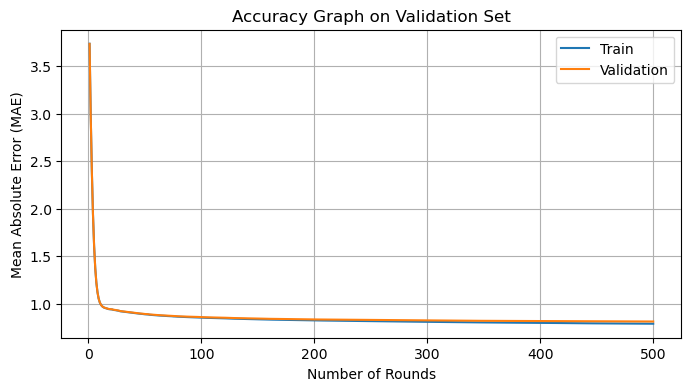

In [44]:
plt.figure(figsize=(8, 4))
plt.plot(epochs, train_scores, label='Train')
plt.plot(epochs, val_scores, label='Validation')
plt.xlabel('Number of Rounds')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Accuracy Graph on Validation Set')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Prediction on test data

In [46]:
minute_pred = minute_model.predict(X_test)

In [47]:
pred = minute_pred*X_test['trip_miles']

In [48]:
MAE(y_test['trip_time'], pred)

2.602361981274182

**Percentage Improvement:**

=  $\frac{LinearRegression − XGBoost}{LinearRegression}$ *x 100*

=  $\frac{4.77 - 2.6}{4.77}$ *x 100*

= ***45.4 %***

### Saving model

In [118]:
# import pickle
# pickle_out = open("xgb_model.pkl", 'wb')
# pickle.dump(minute_model, pickle_out)
# pickle_out.close()